YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Epoch [10/100], Loss: 0.050216
Epoch [20/100], Loss: 0.035008
Epoch [30/100], Loss: 0.029766
Epoch [40/100], Loss: 0.014090
Epoch [50/100], Loss: 0.002502
Epoch [60/100], Loss: 0.002071
Epoch [70/100], Loss: 0.001785
Epoch [80/100], Loss: 0.001481
Epoch [90/100], Loss: 0.001322
Epoch [100/100], Loss: 0.001304
Root Mean Squared Error: 5.22


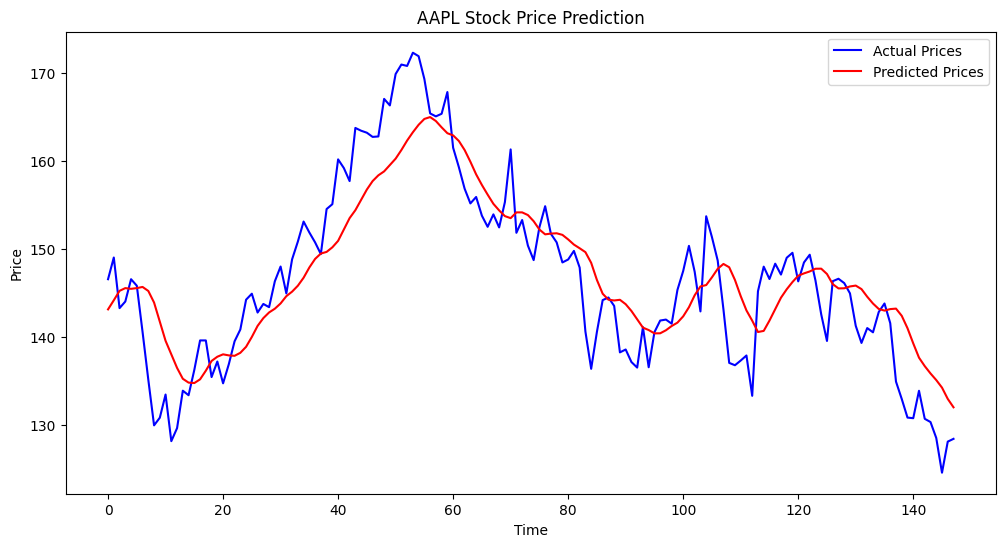

In [1]:
import yfinance as yf
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Download stock data
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')
prices = data['Close'].values.reshape(-1, 1)

# Normalize
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 20
X, y = create_sequences(prices_scaled, seq_length)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Convert to tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

# RNN Model
class StockRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(StockRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Last time step
        return out

model = StockRNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test.numpy())
predictions_inv = scaler.inverse_transform(predictions)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
print(f'Root Mean Squared Error: {rmse:.2f}')

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(predictions_inv, label='Predicted Prices', color='red')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


C:\Users\Shriraj\AppData\Local\Temp\ipykernel_29276\4039688599.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['temperature_celsius'] = data['temperature_celsius'].rolling(window=3).mean().fillna(method='bfill')
C:\Users\Shriraj\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - loss: 0.0246 - val_loss: 0.0074
Epoch 2/10
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 47s 28ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 3/10
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 4/10
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 5/10
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 6/10
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 7/10
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 8/10
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 9/10
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 10/10
1651/1651 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0028 - val_loss: 0.0034
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step

RMSE: 2.27
R² Score: 0.8707


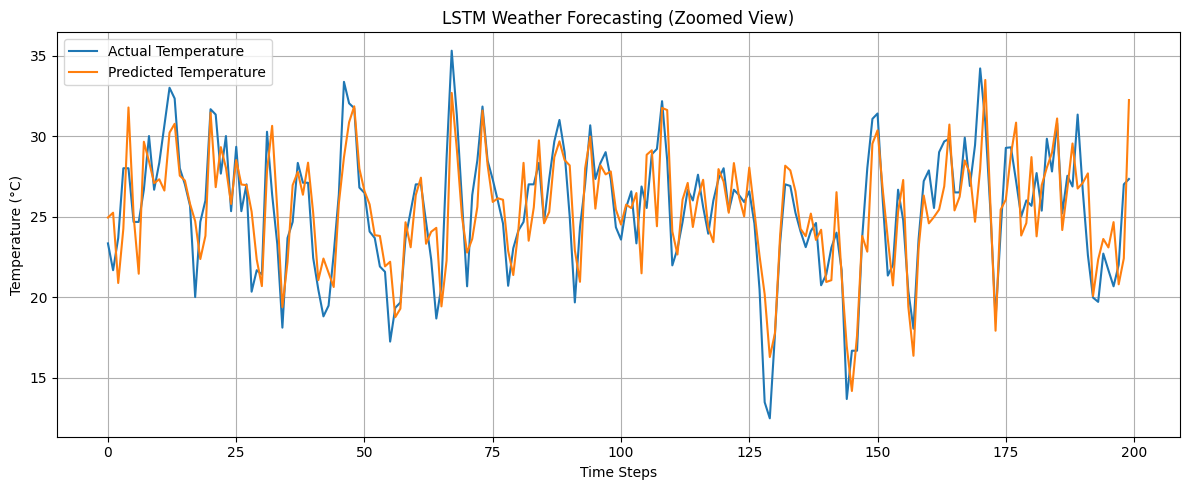

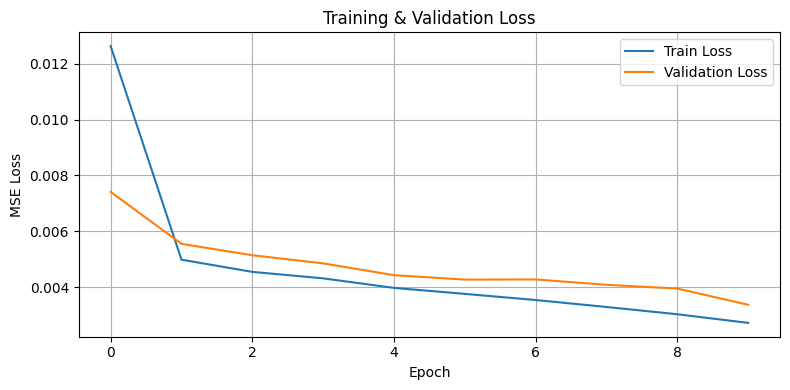

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and smooth data
data = pd.read_csv('GlobalWeatherRepository.csv')
data['temperature_celsius'] = data['temperature_celsius'].rolling(window=3).mean().fillna(method='bfill')

# Extract temperature values and scale
temps = data['temperature_celsius'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_temps = scaler.fit_transform(temps)

# Function to create time-series sequences
def create_dataset(dataset, time_step=30):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step])
        y.append(dataset[i + time_step])
    return np.array(X), np.array(y)

# Prepare dataset with more context (longer time steps)
time_step = 30
X, y = create_dataset(scaled_temps, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM input

# Build improved LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train with validation split
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Predict
predicted_scaled = model.predict(X)
predicted = scaler.inverse_transform(predicted_scaled)
actual = scaler.inverse_transform(y)

# Evaluation
rmse = np.sqrt(mean_squared_error(actual, predicted))
r2 = r2_score(actual, predicted)
print(f"\nRMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot only a subset of the data for clarity
start_idx = 1000
end_idx = 1200

plt.figure(figsize=(12, 5))
plt.plot(actual[start_idx:end_idx], label='Actual Temperature')
plt.plot(predicted[start_idx:end_idx], label='Predicted Temperature')
plt.title("LSTM Weather Forecasting (Zoomed View)")
plt.xlabel("Time Steps")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Optional: Plot training vs validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
